In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split

In [3]:
data = pd.read_csv("./local_data/data_cleaned.csv")

In [4]:
data.columns[data.columns.str.startswith("review_")]

Index(['review_scores_cleanliness', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')

In [5]:
X_raw = data.drop("price", errors="ignore", axis=1).drop(
    [
        "review_scores_cleanliness",
        "review_scores_accuracy",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ],
    axis=1,
    errors="ignore",
)
y = data["price"]

In [6]:
skew_by_col = X_raw.skew().abs().sort_values(ascending=False)
skew_by_col[skew_by_col > 1].head(20)

minimum_minimum_nights                          19.719576
minimum_nights                                  18.991228
maximum_maximum_nights                          17.638736
maximum_nights_avg_ntm                          17.638662
minimum_nights_avg_ntm                          17.474660
calculated_host_listings_count_shared_rooms     17.175993
neighbourhood_cleansed__City                    13.285415
neighbourhood_cleansed__Schwamendingen-Mitte    12.412314
room_type__Shared room                          12.412314
neighbourhood_cleansed__Hochschulen              9.146770
neighbourhood_cleansed__Hirzenbach               8.691415
neighbourhood_cleansed__Lindenhof                8.553441
neighbourhood_cleansed__Escher Wyss              7.735483
beds                                             7.597227
neighbourhood_cleansed__Fluntern                 7.539686
maximum_minimum_nights                           7.195868
neighbourhood_cleansed__Witikon                  6.803804
neighbourhood_

In [7]:
skew_threshold = 1.0
# Initialize transformation lists
bool_cols = []
log_transform_cols = []
yeo_johnson_cols = []
scale_cols = []

# First pass: Identify column types and apply transformations
for col in X_raw.columns:
    # Skip if all values are the same
    if X_raw[col].nunique() <= 1:
        continue

    # Check if boolean (1/0)
    elif set(X_raw[col].unique()).issubset({0, 1, np.nan}):
        bool_cols.append(col)

    # Check if transformation needed
    elif abs(X_raw[col].skew()) > skew_threshold:
        # Try log transformation first (adding small constant to handle zeros)
        eps = 1e-6
        log_transformed = np.log(X_raw[col] - X_raw[col].min() + eps)

        # Compare original vs log-transformed skewness
        original_skew = abs(X_raw[col].skew())
        log_skew = abs(log_transformed.skew())

        if log_skew < original_skew:
            log_transform_cols.append(col)
        else:
            yeo_johnson_cols.append(col)

    else:
        scale_cols.append(col)

In [8]:
# Create copy for transformations
X_raw_transformed = X_raw.copy()

# 1. Apply Yeo-Johnson transformation
pt = PowerTransformer(method="yeo-johnson")
if yeo_johnson_cols:
    X_raw_transformed[yeo_johnson_cols] = pt.fit_transform(X_raw[yeo_johnson_cols])

# 2. Apply log transformation (using log1p which handles zeros better than log)
if log_transform_cols:
    scaler = StandardScaler()
    X_raw_transformed[log_transform_cols] = scaler.fit_transform(
        np.log1p(X_raw[log_transform_cols])
    )

# 3. Apply standard scaling
if scale_cols:
    scaler = StandardScaler()
    X_raw_transformed[scale_cols] = scaler.fit_transform(X_raw[scale_cols])

# Boolean columns remain unchanged

In [9]:
assert len(log_transform_cols) + len(scale_cols) + len(bool_cols) + len(
    yeo_johnson_cols
) == len(X_raw.columns)

In [10]:
X_raw_transformed.skew().abs().sort_values(ascending=False).head(50)

neighbourhood_cleansed__City                    13.285415
calculated_host_listings_count_shared_rooms     13.224878
neighbourhood_cleansed__Schwamendingen-Mitte    12.412314
room_type__Shared room                          12.412314
neighbourhood_cleansed__Hochschulen              9.146770
neighbourhood_cleansed__Hirzenbach               8.691415
neighbourhood_cleansed__Lindenhof                8.553441
neighbourhood_cleansed__Escher Wyss              7.735483
neighbourhood_cleansed__Fluntern                 7.539686
neighbourhood_cleansed__Witikon                  6.803804
neighbourhood_cleansed__Albisrieden              6.733838
host_has_profile_pic                             6.733838
neighbourhood_group_cleansed__Kreis 12           6.665820
neighbourhood_cleansed__Hirslanden               6.665820
neighbourhood_cleansed__Friesenberg              6.599661
neighbourhood_cleansed__Werd                     6.472582
neighbourhood_cleansed__Affoltern                6.182081
neighbourhood_

In [11]:
X_raw_transformed.mean().sort_values(ascending=False).head(50)

host_has_profile_pic                      0.979283
host_identity_verified                    0.960159
has_kitchen                               0.796414
room_type__Entire home/apt                0.769323
has_wifi                                  0.753386
has_essentials                            0.709960
has_hot_water                             0.687649
has_hair_dryer                            0.668127
has_dishes_and_silverware                 0.626295
has_refrigerator                          0.623904
has_cooking_basics                        0.617131
has_hangers                               0.609960
has_bed_linens                            0.590040
has_iron                                  0.582869
host_response_time__within an hour        0.538247
has_dedicated_workspace                   0.525100
has_heating                               0.515538
has_shampoo                               0.479283
has_self_check-in                         0.458566
has_long_term_stays_allowed    

In [12]:
X = X_raw_transformed

## RF


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
cv = KFold(n_splits=5, shuffle=True, random_state=99)

train Metrics:
R² Score: 0.8284
MSE: 6225.99
RMSE: 78.90
MAE: 32.05
test Metrics:
R² Score: 0.4754
MSE: 17080.30
RMSE: 130.69
MAE: 59.15


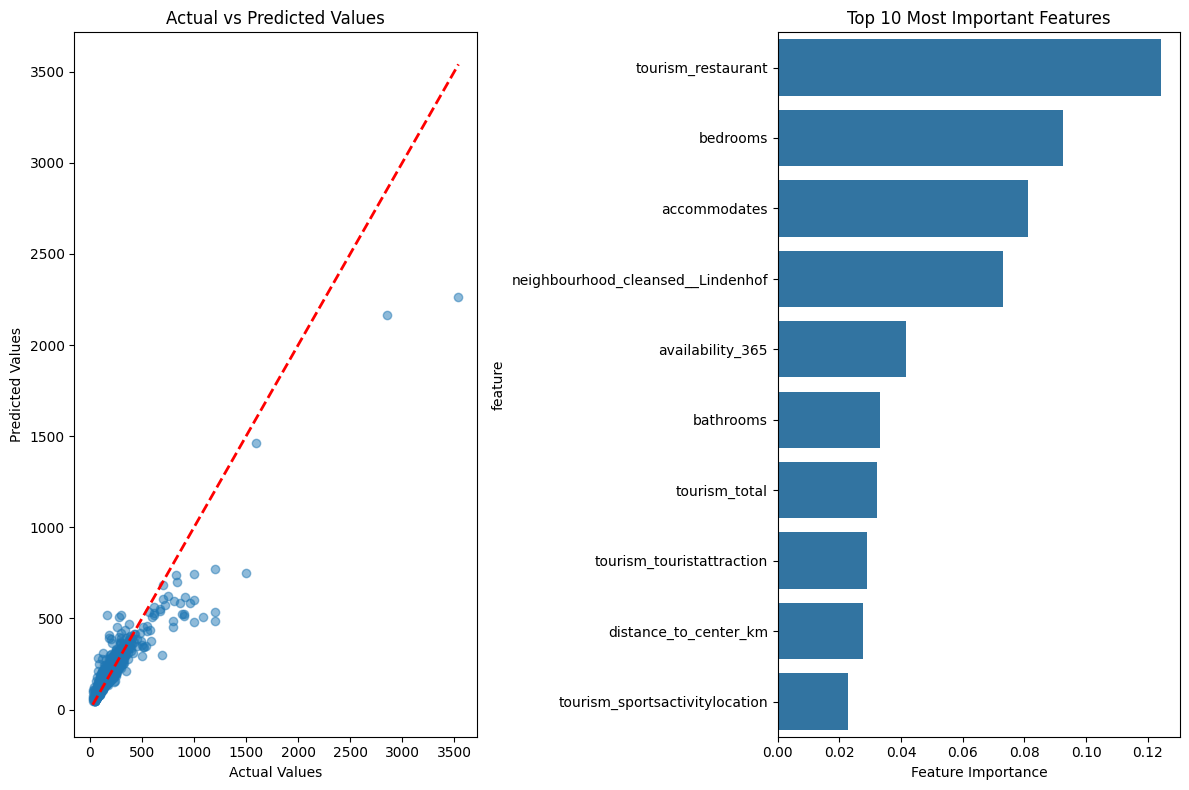

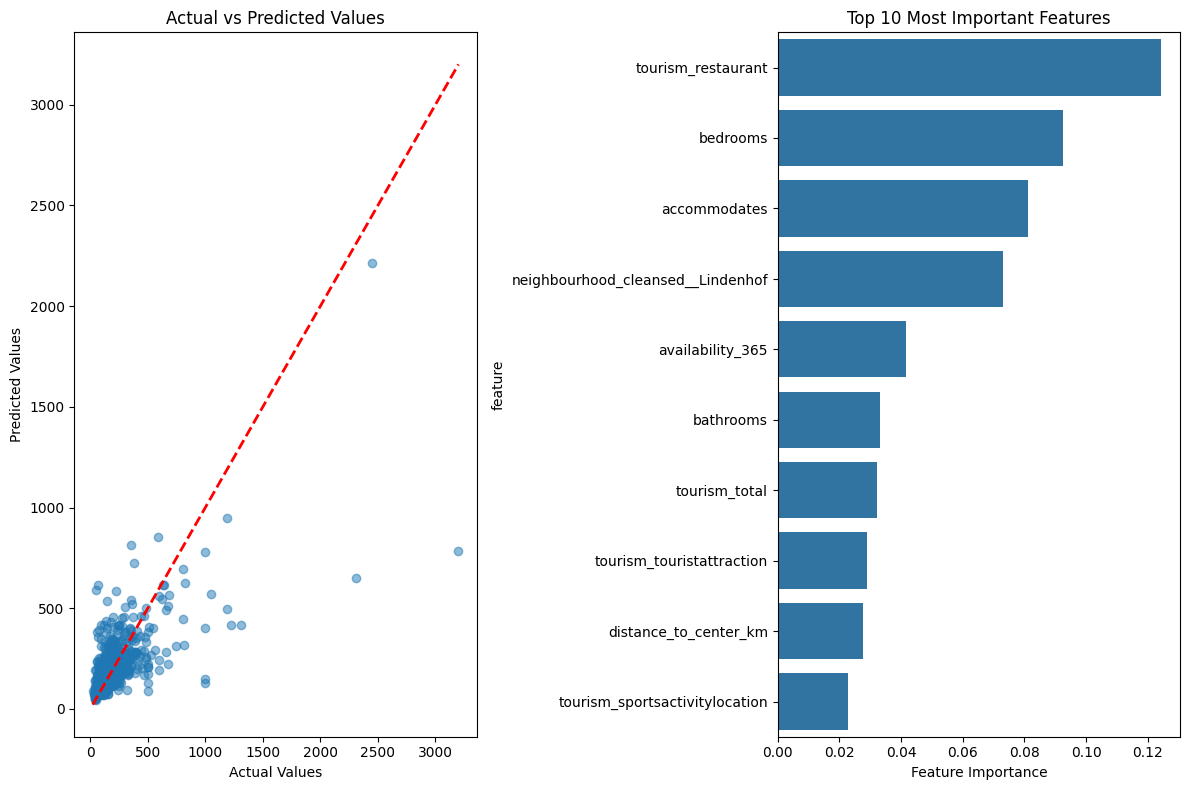

In [14]:
# # find best parameters for random forest
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# rf = RandomForestRegressor()

# param_dist = {
#     "n_estimators": randint(100, 500),
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": randint(2, 20),
#     "min_samples_leaf": randint(1, 10),
# }

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=15,
#     cv=5,
#     scoring="neg_mean_squared_error",
#     n_jobs=-1,
#     random_state=99,
# )
# # random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", random_search.best_score_)

# Random Forest functions


def perform_rf(X_train_scaled, y_train):  # use best parameters in regressor
    rf = RandomForestRegressor(
        n_estimators=155,
        random_state=99,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values(by="importance", ascending=False)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "feature_importance": feature_importance,
    }


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Scatter, actual vs predicted
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0].set_title("Actual vs Predicted Values")
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)

    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1])
    axes[1].set_title("Top 10 Most Important Features")
    axes[1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()


# perform Random forest and evaluate

rf = perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

dict_rf1 = evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features

dict_rf2 = evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(
    y_train, y_train_pred_rf, dict_rf1["feature_importance"]
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features

visualize_rf_performance(y_test, y_test_pred_rf, dict_rf2["feature_importance"])

## Lasso


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=99)

In [17]:
lasso_cv = LassoCV(
    cv=cv,
    random_state=99,
    max_iter=100000,
    alphas=np.logspace(-4, 3, 200),
    selection="random",
    tol=1e-3,
    fit_intercept=True,
)

lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-04, 1.08436597e-04, 1.17584955e-04, 1.27505124e-04,
       1.38262217e-04, 1.49926843e-04, 1.62575567e-04, 1.76291412e-04,
       1.91164408e-04, 2.07292178e-04, 2.24780583e-04, 2.43744415e-04,
       2.64308149e-04, 2.86606762e-04, 3.10786619e-04, 3.37006433e-04,
       3.65438307e-04, 3.96268864e-04, 4.29700470e-04, 4.65952567e-04,
       5.05263107e-04, 5.47890118e-0...
       2.96730241e+02, 3.21764175e+02, 3.48910121e+02, 3.78346262e+02,
       4.10265811e+02, 4.44878283e+02, 4.82410870e+02, 5.23109931e+02,
       5.67242607e+02, 6.15098579e+02, 6.66991966e+02, 7.23263390e+02,
       7.84282206e+02, 8.50448934e+02, 9.22197882e+02, 1.00000000e+03]),
        cv=KFold(n_splits=5, random_state=99, shuffle=True), max_iter=100000,
        random_state=99, selection='random', tol=0.001)

Best regularization parameter: 0.87


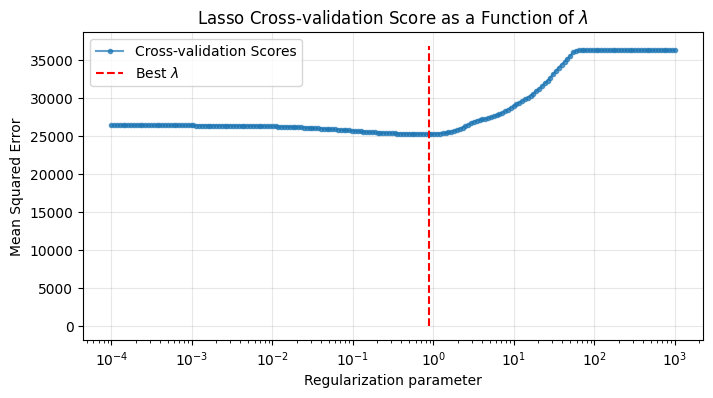

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)
# Plot the final chosen regularization parameter
ax.vlines(
    lasso_cv.alpha_,
    0,
    ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")

In [19]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    """"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)


evaluate_model(y_train, y_train_pred, "train")
evaluate_model(y_test, y_test_pred, "test")


train Metrics:
R² Score: 0.3982
RMSE: 147.76
MAE: 74.45

test Metrics:
R² Score: 0.3656
RMSE: 143.73
MAE: 72.42


\coeffs:
                                             feat       coeff
114             neighbourhood_cleansed__Lindenhof  308.230780
11                         minimum_nights_avg_ntm  -59.586768
57             host_response_time__within an hour  -37.847698
69                               instant_bookable   34.619972
36                              number_of_reviews  -33.504499
74               host_response_time__within a day   32.860009
49                                  has_hot_water  -29.874086
44                                       bedrooms   29.667067
15                                   accommodates   28.675985
59                                    has_heating   27.667506
73                               bathrooms_shared  -26.395080
65                           has_hot_water_kettle  -26.149159
52                               has_refrigerator  -25.685751
30                           host_acceptance_rate   24.374472
7                              tourism_restaurant   23.641055

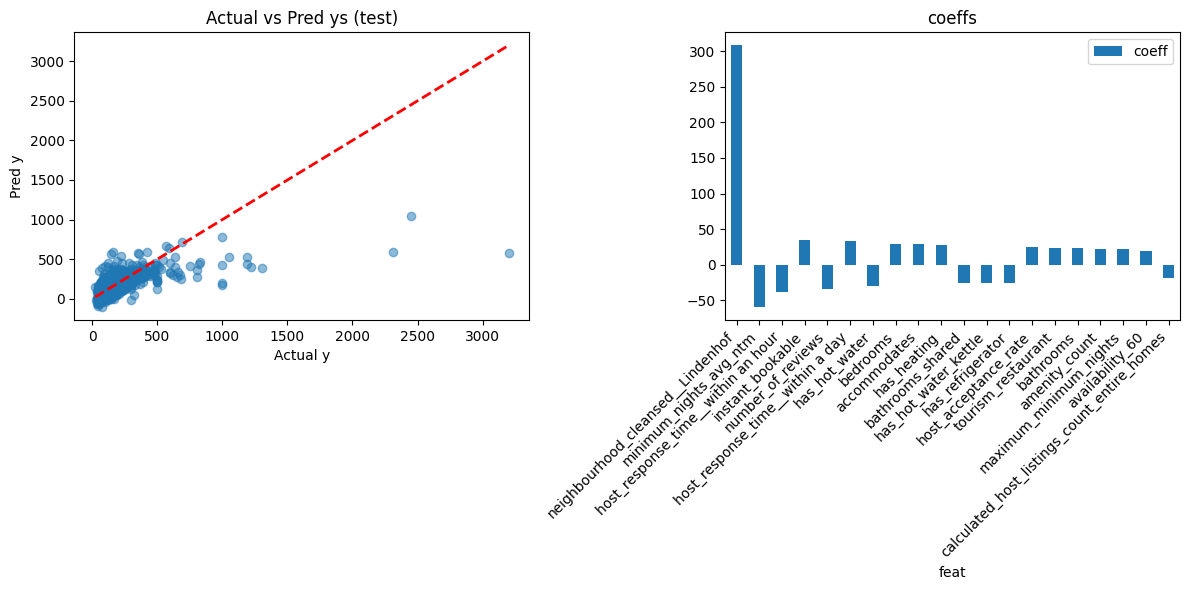

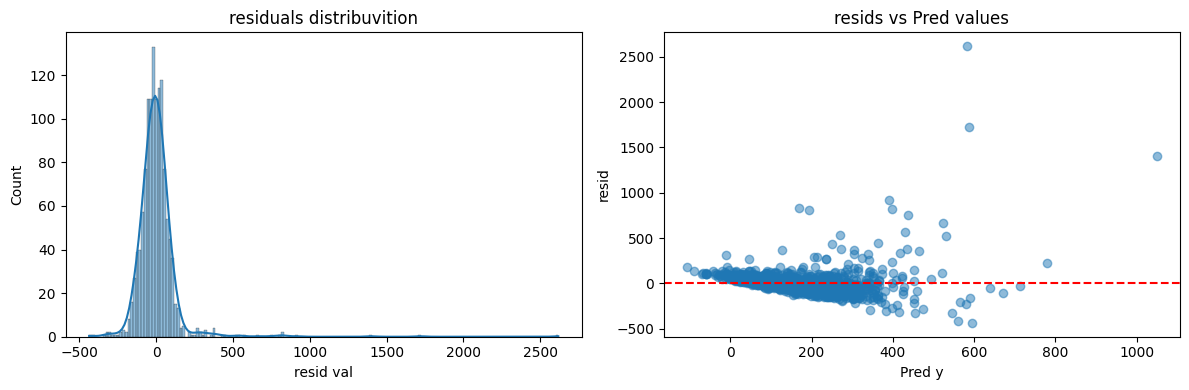

In [20]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.head(20).plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [21]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
114,neighbourhood_cleansed__Lindenhof,308.230780,308.230780
11,minimum_nights_avg_ntm,-59.586768,59.586768
57,host_response_time__within an hour,-37.847698,37.847698
69,instant_bookable,34.619972,34.619972
36,number_of_reviews,-33.504499,33.504499
...,...,...,...
80,neighbourhood_group_cleansed__Kreis 1,0.000000,0.000000
83,neighbourhood_group_cleansed__Kreis 6,0.000000,0.000000
85,neighbourhood_cleansed__Altstetten,0.000000,0.000000
86,neighbourhood_group_cleansed__Kreis 10,0.000000,0.000000
